In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from typing import List, Tuple, Dict, Sequence, Union
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re





In [2]:
pd.options.display.max_rows=75
pd.options.display.max_columns=100


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
import os
print(os.getcwd())  # This prints the current working directory


c:\Users\senth\Desktop\GITHUB\IEEE


In [5]:
# Define the column names for the LIAR dataset
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", 
                "state", "party", "barely_true_counts", "false_counts", "half_true_counts",
                "mostly_true_counts", "pants_on_fire_counts", "context"]

# Load the datasets
train_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\valid.tsv", sep='\t', names=column_names)

# Check the first few rows
train_df.head()


,id,label,statement,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   statement             10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job           7342 non-null   object 
 6   state                 8030 non-null   object 
 7   party                 10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  context               10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [7]:
train_df.sample(2)

,id,label,statement,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
381,11513.json,barely-true,It has been estimated that nearly 40 percent o...,guns,terry-mcauliffe,Governor,Virginia,democrat,12.0,6.0,2.0,2.0,3.0,an executive order.
5838,7473.json,pants-fire,Says Gov. Rick Scott cut more government jobs ...,jobs,florida-democratic-party,NaN,Florida,democrat,5.0,4.0,4.0,5.0,3.0,a memo 'pre-butting' the State of the State ad...


In [8]:
train_df.duplicated().sum()

0

Dataset Overview: 10,240 entries, 14 columns, fact-checking data.
No Duplicates: train_df.duplicated().sum() = 0, ensuring clean data.
Missing Values:
speaker_job (28% missing), state (21.5% missing), context (1% missing).
Data Types:
Categorical: label, statement, subject, speaker, party, etc.
Numerical: barely_true, false, half_true, etc.

In [9]:
def missing_values(data: pd.DataFrame):
    missing_counts = data.isnull().sum()
    missing_percentages = (missing_counts / len(data)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': missing_counts,
        'Percentage': missing_percentages
    })
    
    missing_data = missing_data[missing_data['Missing Count'] > 0]
    
    if not missing_data.empty:
        return missing_data
    else:
        print("No missing values found in the dataset")
        return False


In [10]:
# count of missing values in each column
missing_values_cols  = missing_values(train_df)
missing_values_cols

,Missing Count,Percentage
subject,2,0.019531
speaker,2,0.019531
speaker_job,2898,28.300781
state,2210,21.582031
party,2,0.019531
barely_true_counts,2,0.019531
false_counts,2,0.019531
half_true_counts,2,0.019531
mostly_true_counts,2,0.019531
pants_on_fire_counts,2,0.019531


In [11]:
# filter the rows with missing values and columns based on missing_values_cols
train_df[missing_values_cols.index.values.tolist()].sample(5)

,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
6119,crime,dan-gelber,NaN,Florida,democrat,2.0,2.0,1.0,3.0,0.0,his campaign blog
9401,"cap-and-trade,climate-change,environment,votin...",josh-mandel,Ohio treasurer,Ohio,republican,4.0,5.0,4.0,5.0,6.0,a radio ad
1240,"Alcohol,campaign-finance,ethics,public-service",linda-koop,NaN,Texas,republican,0.0,0.0,0.0,1.0,0.0,a campaign mail flier
6929,state-budget,kelly-cassidy,State representative,Illinois,democrat,1.0,0.0,0.0,0.0,0.0,a Facebook post
4147,"homeland-security,military,terrorism",blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,in various posts on the web


High Missing Data:

speaker_job (28.3%) and state (21.58%) may impact demographic insights.
context (0.99%) missing but manageable.
Minimal Impact on Truth Labels:

barely_true, false, half_true, mostly_true, pants_on_fire missing in only 0.02% of cases.

In [12]:
import pandas as pd
from typing import Tuple

def profile_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Analyzes the dataset and returns summaries for numerical and non-numerical columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Numerical and Non-Numerical Summaries
    '''
    
    # Separate numerical and non-numerical columns
    num_df = df.select_dtypes(exclude='object')
    non_num_df = df.select_dtypes(include='object')

    # Helper functions for analysis
    nuniq = lambda data, col: data[col].nunique()
    missing_pct = lambda data, col: (data[col].isnull().sum() / data.shape[0]) * 100
    mode = lambda data, col: data[col].mode().tolist()
    top_five = lambda data, col: data[col].value_counts().head(5).index.tolist()

    # Numerical Summary
    num_summary = num_df.describe().T
    num_summary['unique'] = [nuniq(num_df, col) for col in num_df.columns]
    num_summary['missing_pct'] = [missing_pct(num_df, col) for col in num_df.columns]
    num_summary['top'] = [mode(num_df, col) for col in num_df.columns]
    num_summary['top_five'] = [top_five(num_df, col) for col in num_df.columns]
    num_summary['dtype'] = num_df.dtypes

    # Non-Numerical Summary
    non_num_summary = non_num_df.describe().T
    non_num_summary['missing_pct'] = [missing_pct(non_num_df, col) for col in non_num_df.columns]
    non_num_summary['top_five'] = [top_five(non_num_df, col) for col in non_num_df.columns]

    return num_summary, non_num_summary


In [13]:
import pandas as pd

# Define the correct path to your dataset
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

# Load the dataset
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job",
                "state", "party", "barely_true_counts", "false_counts",
                "half_true_counts", "mostly_true_counts", "pants_on_fire_counts",
                "context"]

liar_df = pd.read_csv(file_path, sep='\t', names=column_names)

# Verify if the dataset is loaded
print(liar_df.head())  # Display the first few rows


           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true_c

In [14]:
numerical_summary, non_numerical_summary = profile_dataset(liar_df)

# Display the summaries
print("\nNumerical Summary:\n", numerical_summary)
print("\nNon-Numerical Summary:\n", non_numerical_summary)


Numerical Summary:
                         count       mean        std  min  25%  50%   75%  \
barely_true_counts    10238.0  11.533210  18.973764  0.0  0.0  2.0  12.0   
false_counts          10238.0  13.286482  24.112936  0.0  0.0  2.0  12.0   
half_true_counts      10238.0  17.133718  35.846511  0.0  0.0  3.0  13.0   
mostly_true_counts    10238.0  16.434265  36.151688  0.0  0.0  3.0  11.0   
pants_on_fire_counts  10238.0   6.201407  16.128927  0.0  0.0  1.0   5.0   

                        max  unique  missing_pct    top  \
barely_true_counts     70.0      30     0.019531  [0.0]   
false_counts          114.0      30     0.019531  [0.0]   
half_true_counts      160.0      29     0.019531  [0.0]   
mostly_true_counts    163.0      27     0.019531  [0.0]   
pants_on_fire_counts  105.0      20     0.019531  [0.0]   

                                        top_five    dtype  
barely_true_counts    [0.0, 1.0, 2.0, 3.0, 70.0]  float64  
false_counts          [0.0, 1.0, 2.0, 5.0, 71.0

In [15]:
numerical_summary

,count,mean,std,min,25%,50%,75%,max,unique,missing_pct,top,top_five,dtype
barely_true_counts,10238.0,11.533210,18.973764,0.0,0.0,2.0,12.0,70.0,30,0.019531,[0.0],"[0.0, 1.0, 2.0, 3.0, 70.0]",float64
false_counts,10238.0,13.286482,24.112936,0.0,0.0,2.0,12.0,114.0,30,0.019531,[0.0],"[0.0, 1.0, 2.0, 5.0, 71.0]",float64
half_true_counts,10238.0,17.133718,35.846511,0.0,0.0,3.0,13.0,160.0,29,0.019531,[0.0],"[0.0, 1.0, 2.0, 3.0, 4.0]",float64
mostly_true_counts,10238.0,16.434265,36.151688,0.0,0.0,3.0,11.0,163.0,27,0.019531,[0.0],"[0.0, 1.0, 2.0, 5.0, 3.0]",float64
pants_on_fire_counts,10238.0,6.201407,16.128927,0.0,0.0,1.0,5.0,105.0,20,0.019531,[0.0],"[0.0, 1.0, 3.0, 9.0, 2.0]",float64


In [16]:
print(liar_df.columns)


Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state', 'party', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


In [17]:
numerical_columns_df = liar_df[["barely_true_counts", "false_counts", "half_true_counts", 
                                "mostly_true_counts", "pants_on_fire_counts", "label"]]

print(numerical_columns_df.head())  # Check the extracted data


   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           1.0               0.0                 0.0   
1                 0.0           0.0               1.0                 1.0   
2                70.0          71.0             160.0               163.0   
3                 7.0          19.0               3.0                 5.0   
4                15.0           9.0              20.0                19.0   

   pants_on_fire_counts        label  
0                   0.0        false  
1                   0.0    half-true  
2                   9.0  mostly-true  
3                  44.0        false  
4                   2.0    half-true  


In [18]:
numerical_columns_df.sample(10)

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,label
4759,30.0,30.0,42.0,23.0,18.0,half-true
6796,0.0,1.0,0.0,0.0,0.0,true
6736,8.0,3.0,15.0,15.0,0.0,true
6324,31.0,39.0,31.0,37.0,8.0,mostly-true
8874,40.0,29.0,69.0,76.0,7.0,pants-fire
1371,0.0,0.0,0.0,1.0,0.0,mostly-true
8805,40.0,29.0,69.0,76.0,7.0,mostly-true
9804,0.0,2.0,0.0,1.0,0.0,false
4483,0.0,1.0,0.0,0.0,0.0,false
5024,6.0,9.0,3.0,1.0,4.0,false


In [19]:
numerical_columns_df[numerical_columns_df['label']==5]

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,label


In [20]:
numerical_columns_df.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407
std,18.973764,24.112936,35.846511,36.151688,16.128927
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [21]:
numerical_features = [feature for feature in numerical_columns_df.columns]

discrete_feature=[feature for feature in numerical_features if len(train_df[feature].unique())<10]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))


Discrete Variables Count: 1
Continuous feature Count 5


In [22]:
print('Discrete Variables')
train_df[discrete_feature].head()

Discrete Variables


,label
0,false
1,half-true
2,mostly-true
3,false
4,half-true


In [23]:
print('Continuous Variables')
train_df[continuous_feature].head()

Continuous Variables


,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,70.0,71.0,160.0,163.0,9.0
3,7.0,19.0,3.0,5.0,44.0
4,15.0,9.0,20.0,19.0,2.0


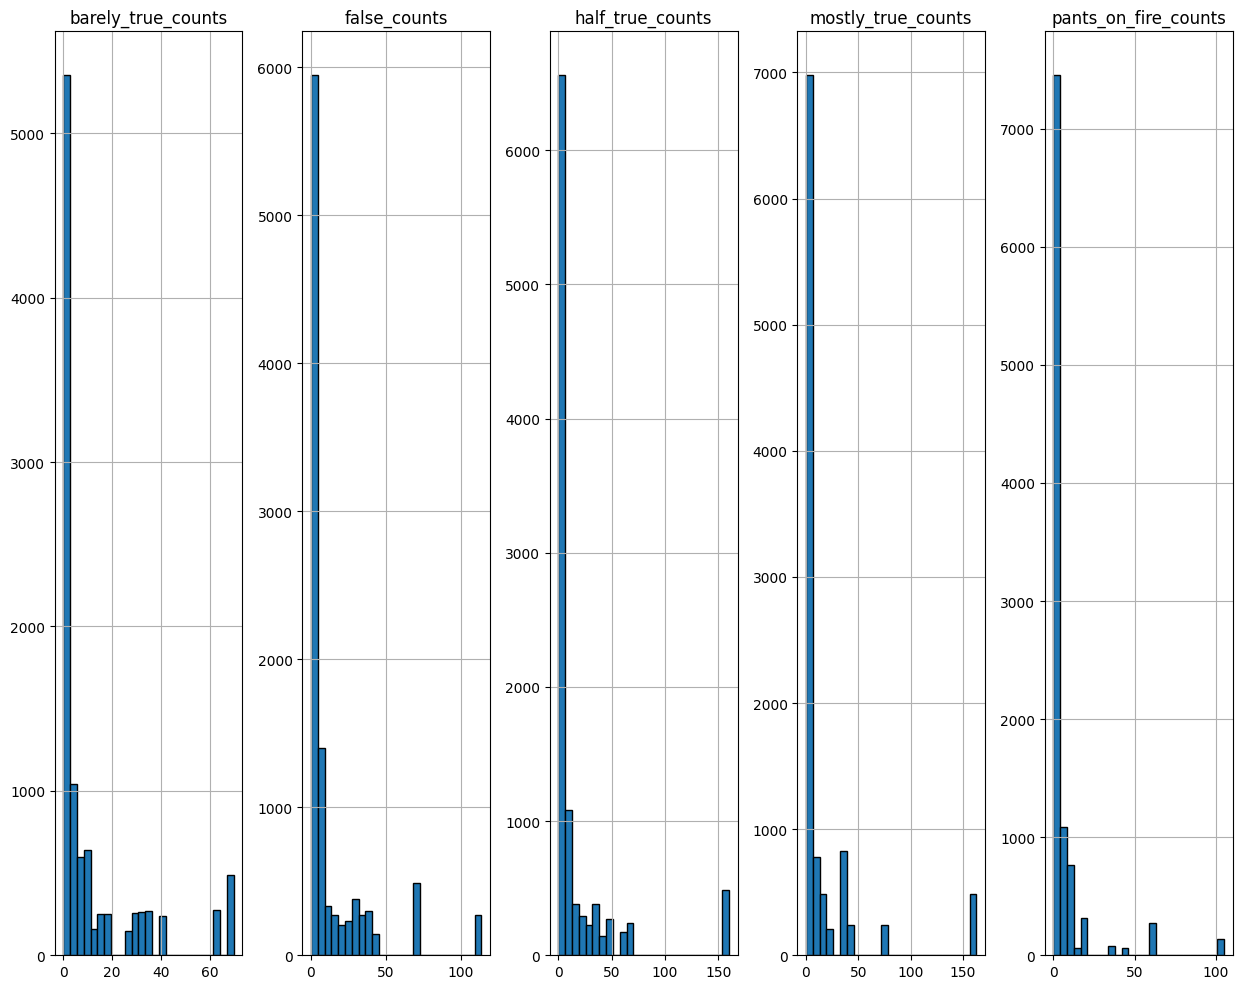

In [24]:
train_df[continuous_feature].hist(bins=25, figsize=(15, 10), layout=(-1, 6), edgecolor="black")
plt.tight_layout()

In [25]:
# non numerical columns summary
non_numerical_summary

,count,unique,top,freq,missing_pct,top_five
id,10240,10240,2635.json,1,0.000000,"[2635.json, 10540.json, 571.json, 4285.json, 1..."
label,10240,6,half-true,2114,0.000000,"[half-true, false, mostly-true, true, barely-t..."
statement,10240,10223,On changing the rules for filibusters on presi...,3,0.000000,[On changing the rules for filibusters on pres...
subject,10238,3827,health-care,381,0.019531,"[health-care, taxes, immigration, elections, e..."
speaker,10238,2910,barack-obama,488,0.019531,"[barack-obama, donald-trump, hillary-clinton, ..."
speaker_job,7342,1183,President,492,28.300781,"[President, U.S. Senator, Governor, President-..."
state,8030,83,Texas,1009,21.582031,"[Texas, Florida, Wisconsin, New York, Illinois]"
party,10238,23,republican,4497,0.019531,"[republican, democrat, none, organization, ind..."
context,10138,4345,a news release,241,0.996094,"[a news release, an interview, a press release..."


In [26]:
non_numerical_columns_df = liar_df[["speaker", "speaker_job", "statement", 
                                    "subject", "context", "state", "party"]]




In [27]:
non_numerical_columns_df.sample(5)

,speaker,speaker_job,statement,subject,context,state,party
8361,david-brooks,NaN,Newt Gingrich has suggested building a mirror ...,"history,science,space",a column in the New York Times,NaN,none
6487,debbie-wasserman-schultz,"U.S. Representative, Florida District 23",Dan Webster supports privatization of Social S...,social-security,an interview on CNN,Florida,democrat
2478,tim-kaine,U.S. Senator,Pinnacle Overlook in Southwest Virginia is clo...,states,a tweet.,Virginia,democrat
1278,scott-walker,Milwaukee County Executive,The University of Wisconsin System had a jobs-...,education,a radio interview,Wisconsin,republican
3296,chris-larson,Wisconsin Senate Minority Leader,Says Chris Abele has had five years and hes do...,environment,a speech,Wisconsin,democrat


In [28]:

def clean_data(text: str ,lower_case = False, allow_digits = True, allow_special_chars = False, allow_punctuations = True)->str:
    text = str(text)
    if lower_case:
        text = text.lower()
    text = re.sub("'s", "", text)
    text = re.sub("'ve", "", text)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  # Remove duplicate words
    text = re.sub(r'([\d]+)', r' \1 ', text)
    text = re.sub(r'([.,-/!&*@#\/()])', r' \1 ', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Limit repeated characters
    
    if allow_digits:
        text = re.sub(r'[^a-zA-Z0-9.,_()$\-\'/ ]', '', text)
    else:
        text = re.sub(r'[^a-zA-Z_().,$\-\'/ ]', '', text)
    
    if not allow_special_chars:
        text = re.sub(r'[_()$\+\-\'/]', '', text)
    if not allow_punctuations:
        text = re.sub(r'[.,!:;]', '', text)
    
    text = re.sub(' +', ' ', text).strip()  # Remove multiple spaces and trim
    return text

def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

def univariate_text_analysis(data: pd.DataFrame, text_column: str):
    if text_column not in data.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame")
    
    data[text_column] = data[text_column].apply(lambda x: clean_data(x, lower_case=True, allow_digits=False, allow_special_chars=False, allow_punctuations=False))
    data[text_column] = data[text_column].apply(preprocess_text)
    text_data = data[text_column].dropna()
    
    unique_values = text_data.nunique()
    top_values = text_data.value_counts().head(10)
    all_words = " ".join(text_data.astype(str)).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(10)
    text_lengths = text_data.astype(str).apply(len)
    
    print(f"Total Unique Values: {unique_values}")
    print("\nTop 10 Most Frequent Text Entries:\n", top_values)
    print("\nMost Common Words:\n", most_common_words)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    words, counts = zip(*most_common_words)
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.xlabel("Count")
    plt.title("Top 10 Most Frequent Words")
    
    plt.subplot(1, 2, 2)
    sns.histplot(text_lengths, bins=20, kde=True, color="skyblue")
    plt.xlabel("Text Length")
    plt.title("Distribution of Text Lengths")
    plt.tight_layout()
    plt.show()
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Text Data")
    plt.show()

In [29]:
clean_data("this is a test 1234", lower_case=True, allow_digits=False, allow_special_chars=False, allow_punctuations=False)

'this is a test'

In [30]:
non_numerical_columns_df.columns

Index(['speaker', 'speaker_job', 'statement', 'subject', 'context', 'state',
       'party'],
      dtype='object')

Numerical Data:
12,789 entries across five numerical columns.
Mean values range from 6.25 (pants_on_fire) to 17.18 (half_true).
High variance in half_true (35.85) and mostly_true (36.16).
Most frequent value: 0 in all categories.
Minimal missing values (0.015%).

Non-Numerical Data:
Labels: Six categories, most frequent is half-true (2,627).
Subjects & Speakers: Common topics include healthcare, Barack Obama.
State & Speaker Job: Missing values (21.5% and 27.8%), Texas and President are most frequent.
Party: Dominated by Republican & Democrat.

<Axes: xlabel='state'>

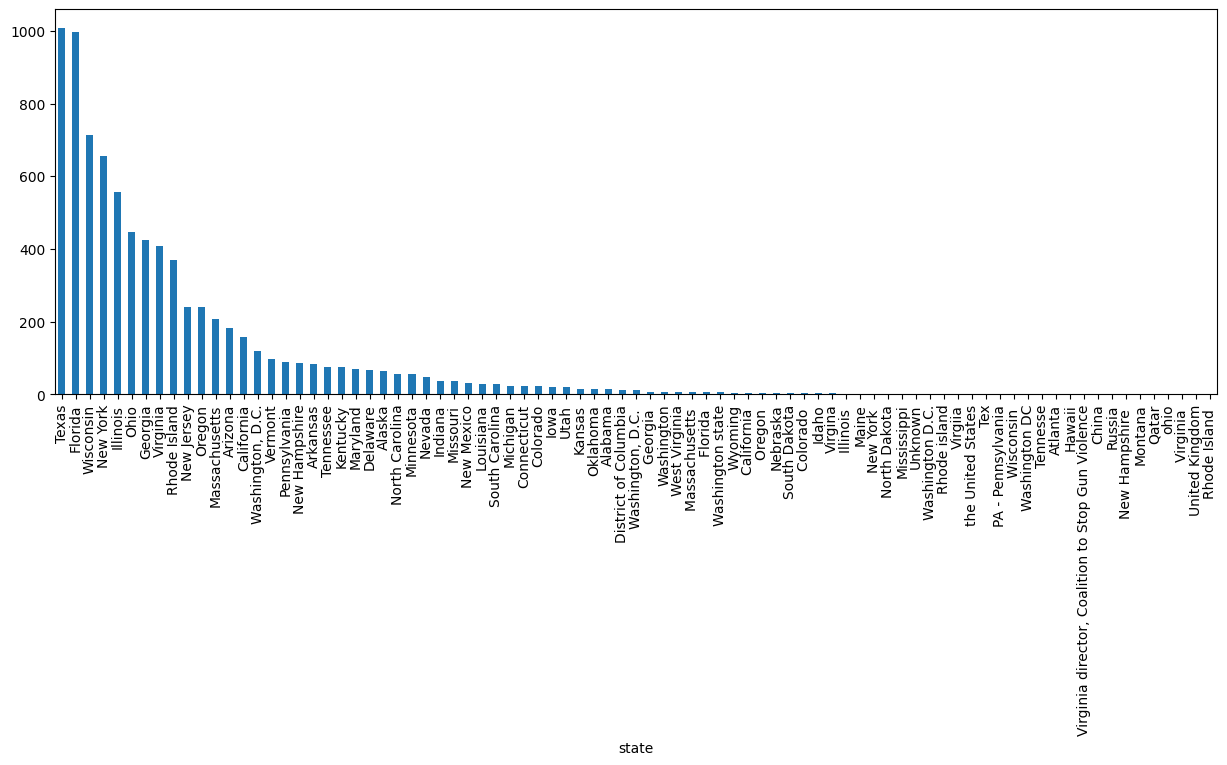

In [31]:
# state_info column
non_numerical_columns_df['state'].value_counts().plot(kind='bar', figsize=(15, 5))

Column: speaker
Unique values: 2910
speaker
barack-obama       488
donald-trump       273
hillary-clinton    239
mitt-romney        176
scott-walker       149
john-mccain        148
rick-perry         142
chain-email        142
marco-rubio        117
rick-scott         115
Name: count, dtype: int64


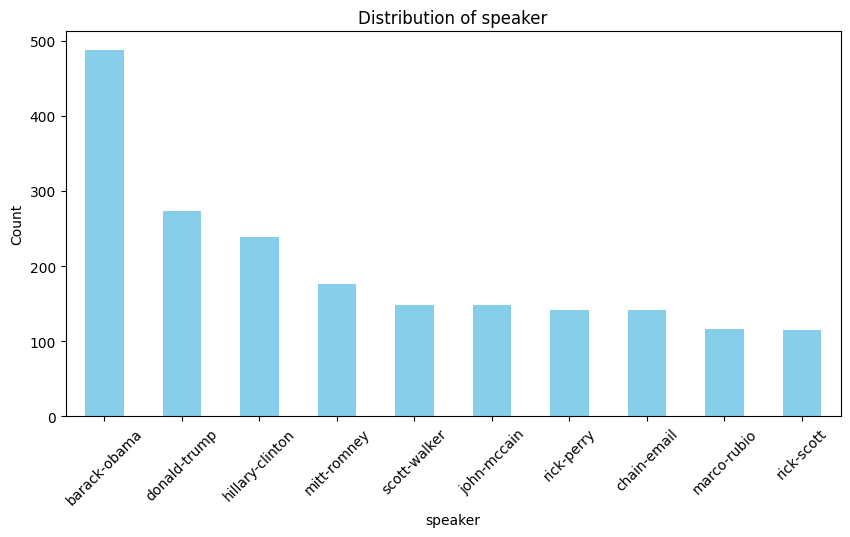

Column: subject
Unique values: 3827
subject
health-care             381
taxes                   308
immigration             253
elections               252
education               237
candidates-biography    190
economy                 137
guns                    130
economy,jobs            125
federal-budget          121
Name: count, dtype: int64


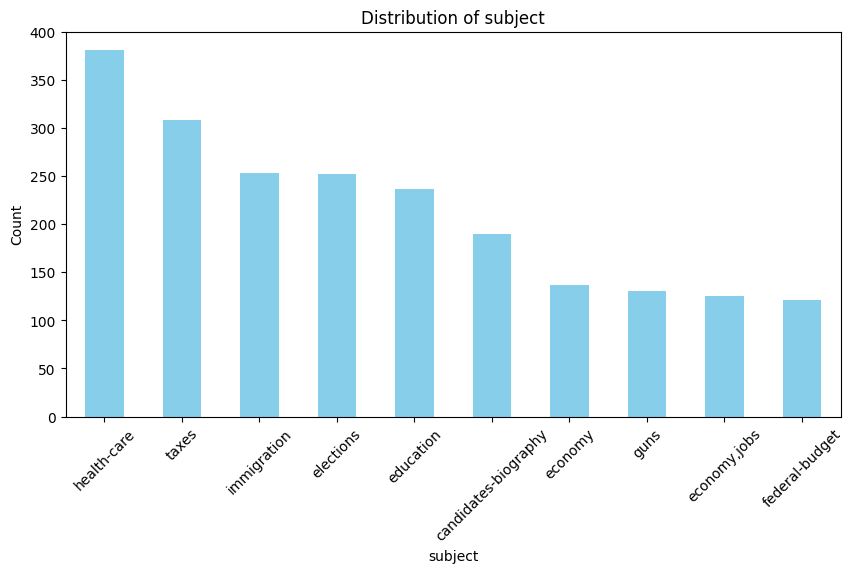

Column: context
Unique values: 4345
context
a news release       241
an interview         229
a press release      223
a speech             214
a TV ad              180
a tweet              156
a campaign ad        132
a television ad      123
a radio interview    106
a debate              92
Name: count, dtype: int64


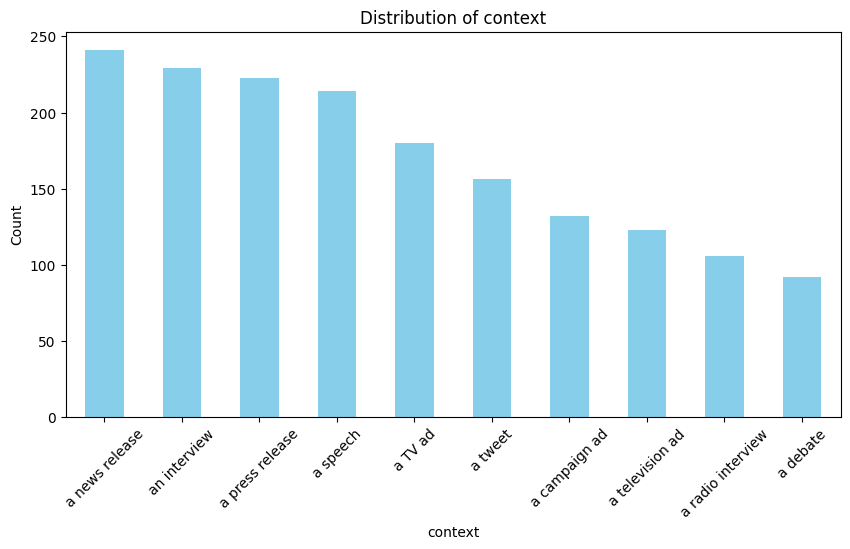

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


# List of non-numeric columns (modify based on your dataset)
non_numeric_cols = ['speaker', 'speaker_description', 'subject', 'party_affiliation', 'context']  # Add more if needed

# Function for univariate analysis
def univariate_analysis(data, column):
    print(f"Column: {column}")
    print("Unique values:", data[column].nunique())  # Count of unique categories
    print(data[column].value_counts().head(10))  # Show top 10 most frequent values
    
    # Plot bar chart
    plt.figure(figsize=(10, 5))
    data[column].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
# Apply analysis to each non-numeric column
for col in non_numeric_cols:
    if col in train_df.columns:
        univariate_analysis(train_df, col)


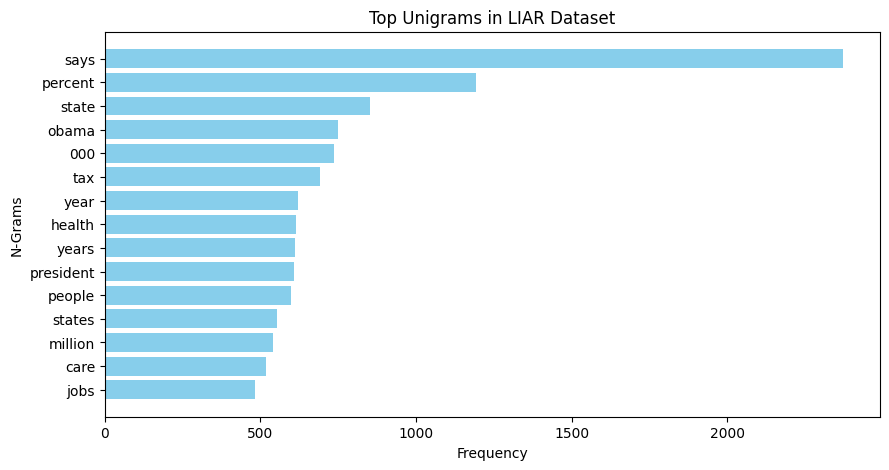

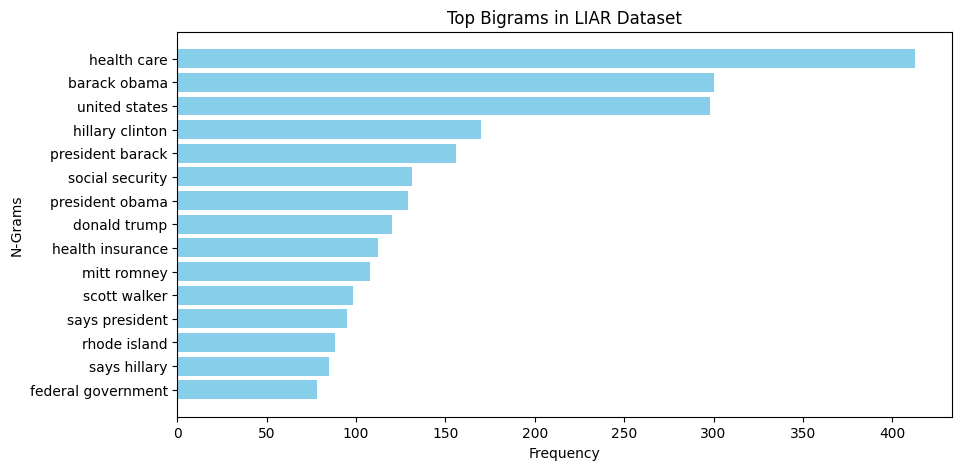

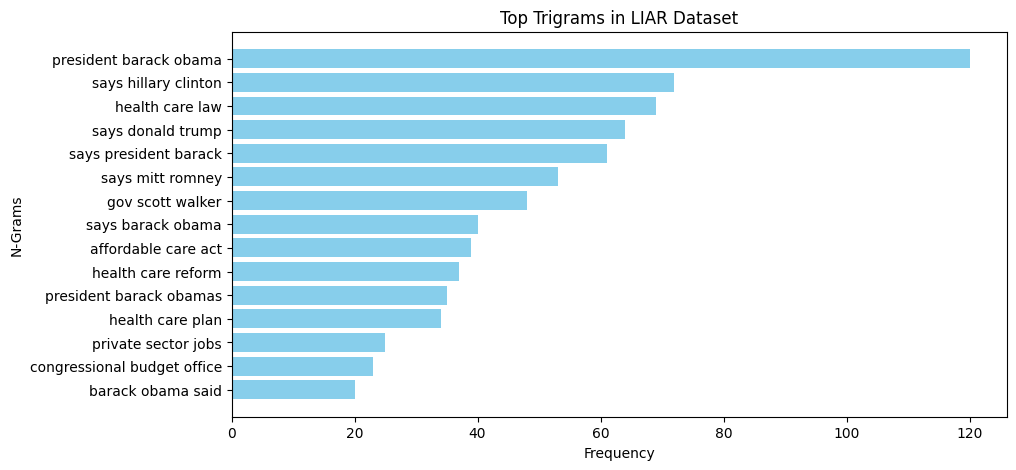

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re

# Load the dataset
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", 
                "state", "party", "barely_true_counts", "false_counts", "half_true_counts",
                "mostly_true_counts", "pants_on_fire_counts", "context"]

train_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv", sep='\t', names=column_names)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    return text

train_df['cleaned_statement'] = train_df['statement'].apply(clean_text)

# Function to extract n-grams
def get_top_ngrams(corpus, ngram_range=(1, 1), n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.toarray().sum(axis=0)
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts))
    return Counter(ngram_freq).most_common(n)

# Extract Unigrams, Bigrams, and Trigrams
top_unigrams = get_top_ngrams(train_df['cleaned_statement'], ngram_range=(1, 1), n=15)
top_bigrams = get_top_ngrams(train_df['cleaned_statement'], ngram_range=(2, 2), n=15)
top_trigrams = get_top_ngrams(train_df['cleaned_statement'], ngram_range=(3, 3), n=15)

# Function to plot n-grams
def plot_ngrams(ngrams, title):
    words = [word[0] for word in ngrams]
    counts = [word[1] for word in ngrams]
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("N-Grams")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot Unigrams, Bigrams, and Trigrams
plot_ngrams(top_unigrams, "Top Unigrams in LIAR Dataset")
plot_ngrams(top_bigrams, "Top Bigrams in LIAR Dataset")
plot_ngrams(top_trigrams, "Top Trigrams in LIAR Dataset")


In [34]:
print(train_df.columns)  # List all column names


Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state', 'party', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'cleaned_statement'],
      dtype='object')


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [36]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the LIAR dataset
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job",
                "state", "party", "barely_true_counts", "false_counts",
                "half_true_counts", "mostly_true_counts", "pants_on_fire_counts",
                "context"]

train_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv", sep='\t', names=column_names)

# Function for text preprocessing
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply preprocessing
train_df["processed_statement"] = train_df["statement"].apply(preprocess_text)

# ✅ TF-IDF Vectorization (Unigram, Bigram, Trigram)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(train_df["processed_statement"])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Find rare words (words appearing in very few samples)
word_counts = (tfidf_df > 0).sum(axis=0)
rare_words = word_counts[word_counts < 2].index.tolist()  # Words appearing in <2 samples

# ✅ Fix: Compute contribution using `tfidf_df` grouped by `train_df["label"]`
rare_word_contribution = tfidf_df.groupby(train_df["label"]).sum()

# Display results
print("\nTF-IDF Rare Word Contribution to Fake News Classification:\n")
print(rare_word_contribution)

# Save results to CSV
rare_word_contribution.to_csv("rare_word_contribution.csv")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



TF-IDF Rare Word Contribution to Fake News Classification:

                    10  10 million  10 percent  10 years       100  \
label                                                                
barely-true   4.978169    0.270810    1.068622  1.671668  4.471086   
false         7.220812    0.351814    1.599083  3.575881  2.704387   
half-true     9.609133    0.305123    2.764450  3.034891  5.974278   
mostly-true  11.381103    0.000000    3.568853  3.186658  5.205650   
pants-fire    1.389259    0.550682    0.264459  0.850811  1.484186   
true          7.480343    0.320257    2.293174  2.488952  4.331846   

             100 billion  100 million  100 percent  100 years      1000  \
label                                                                     
barely-true     0.000000     0.661164     0.664400   0.000000  1.108879   
false           0.684737     0.324085     0.790623   0.421531  0.587713   
half-true       0.428379     1.149984     2.350052   1.154266  2.592880   
mos

In [37]:
import torch
print(torch.__version__)


2.6.0+cpu


In [38]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
print("SentenceTransformer loaded successfully!")


SentenceTransformer loaded successfully!


In [39]:

import pandas as pd
import os

# ✅ File path to your dataset
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

# ✅ Check if the file exists
if os.path.exists(file_path):
    print("✅ File found! Loading dataset...")
    
    # Define column names as per LIAR dataset format
    column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job",
                    "state", "party", "barely_true_counts", "false_counts",
                    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts",
                    "context"]
    
    # ✅ Load dataset
    df = pd.read_csv(file_path, sep='\t', names=column_names)
    
    print("✅ Dataset loaded successfully!")
    
    # ✅ Show first few rows
    print(df.head())

    # ✅ Check column names
    print("Columns in the dataset:", df.columns.tolist())

else:
    print("❌ File not found! Please check the path.")


✅ File found! Loading dataset...
✅ Dataset loaded successfully!
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist 

In [40]:
# Define the correct path to your dataset
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

In [41]:
import pandas as pd
import os

# ✅ File path
df= r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

# ✅ Check if file exists
if os.path.exists(file_path):
    print("✅ File found! Loading dataset...")
    
    column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job",
                    "state", "party", "barely_true_counts", "false_counts",
                    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts",
                    "context"]
    
    # ✅ Load dataset
    df = pd.read_csv(file_path, sep='\t', names=column_names, header=None, dtype=str)

    print("✅ Dataset loaded successfully!")
    print(df.head())  # Display first rows
    print("Columns in dataset:", df.columns.tolist())

    # ✅ Label encoding
    label_mapping = {
        "pants-fire": 0, "false": 1, "barely-true": 2, 
        "half-true": 3, "mostly-true": 4, "true": 5
    }

    if "label" in df.columns:
        df["label"] = df["label"].map(label_mapping)
        print("✅ Labels mapped successfully!")
    else:
        print("❌ 'label' column not found!")

else:
    print("❌ File not found! Please check the path.")


✅ File found! Loading dataset...
✅ Dataset loaded successfully!
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist 

In [42]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ✅ Download stopwords (only once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# ✅ Function to clean text
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# ✅ Apply preprocessing
df["clean_statement"] = df["statement"].apply(preprocess_text)


In [44]:
# ✅ Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# ✅ Transform statements into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_statement"])

print(f"🔍 TF-IDF Matrix Shape: {tfidf_matrix.shape}")  # Should print (num_samples, num_features)


🔍 TF-IDF Matrix Shape: (10240, 12061)


In [45]:
import numpy as np

# ✅ Get indices of true and fake news
true_indices = df[df["label"] == "true"].index
fake_indices = df[df["label"] == "false"].index

# ✅ Compute pairwise cosine similarity
cos_similarities = cosine_similarity(tfidf_matrix)

# ✅ Compute average similarity between fake and true news
similarity_scores = []
for fake_idx in fake_indices:
    for true_idx in true_indices:
        similarity_scores.append(cos_similarities[fake_idx, true_idx])

avg_similarity = np.mean(similarity_scores)
print(f"🔍 Average Cosine Similarity between Fake and True News (TF-IDF): {avg_similarity:.4f}")


🔍 Average Cosine Similarity between Fake and True News (TF-IDF): nan


c:\Users\senth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\senth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [46]:
import pandas as pd

# 🔍 Load dataset
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

# Try different delimiters
try:
    df = pd.read_csv(file_path, sep="\t")  # TSV format
except:
    df = pd.read_csv(file_path, sep=",")  # CSV format

# Display dataset information
print("🔍 First 5 rows:")
print(df.head())

print("\n🔍 Column Names:")
print(df.columns.tolist())

print("\n🔍 Unique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


🔍 First 5 rows:
    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
2   1123.json        false   
3   9028.json    half-true   
4  12465.json         true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
2  Health care reform legislation is likely to ma...                                   
3  The economic turnaround started at the end of ...                                   
4  The Chicago Bears have had more starting quart...                                   

                             abortion    dwayne-bohac  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charli

In [47]:
import pandas as pd

# 🔍 Load dataset with correct headers
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

df = pd.read_csv(file_path, sep="\t", header=None)  # Load without header

# Manually define column names based on LIAR dataset structure
df.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", 
              "state", "party", "barely_true_counts", "false_counts", 
              "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

# 🔍 Display first 5 rows
print(df.head())

# 🔍 Confirm column names
print("\nColumns:", df.columns.tolist())

# 🔍 Check unique labels
print("\nUnique labels:", df["label"].unique())


           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker         speaker_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true_c

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 🔍 Use the "statement" column for text analysis
statements = df["statement"].astype(str)  # Convert to string (avoid NaN issues)

# 🔹 Step 1: Apply TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(statements)

# 🔍 Step 2: Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# 🔹 Step 3: Print insights
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)  # Check dimensions
print("\nSample Cosine Similarity Values (first 5x5 matrix):\n", cosine_sim[:5, :5])

# 🔹 Step 4: Find most similar statements (example for first statement)
most_similar_idx = np.argsort(-cosine_sim[0])[1:6]  # Get top 5 similar indices (excluding itself)
print("\nMost similar statements to the first one:")
for idx in most_similar_idx:
    print(f"- {df.iloc[idx]['statement']} (Label: {df.iloc[idx]['label']})")


TF-IDF Matrix Shape: (10240, 5000)

Sample Cosine Similarity Values (first 5x5 matrix):
 [[1.         0.         0.         0.         0.        ]
 [0.         1.         0.06156088 0.         0.21622433]
 [0.         0.06156088 1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.21622433 0.         0.         1.        ]]

Most similar statements to the first one:
- Says abortions are decreasing. (Label: true)
- Judithanne McLauchlan was part of a group that supports imposing a state income tax on Floridians. (Label: barely-true)
- A defense bill includes language that would require military hospitals to provide abortions on demand. (Label: false)
- Says Russ Feingold formed his own political group to pay himself and his staff millions. (Label: half-true)
- Says Jill McCabe supports late term abortions. Larger baby parts are more profitable. (Label: pants-fire)


In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# 🔹 Convert categorical columns to numerical
categorical_cols = ['speaker', 'party', 'speaker_title', 'state']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")  # Handle missing values
    df[col] = label_encoders[col].fit_transform(df[col])

# 🔹 Numeric Columns
numeric_cols = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                'mostly_true_counts', 'pants_on_fire_counts']
df[numeric_cols] = df[numeric_cols].fillna(0)  # Replace NaN with 0

# 🔹 Apply TF-IDF on "statement" and "subject"
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_statement = tfidf_vectorizer.fit_transform(df['statement'].astype(str))
tfidf_subject = tfidf_vectorizer.fit_transform(df['subject'].astype(str))

# 🔹 Combine all features
X = hstack([tfidf_statement, tfidf_subject, df[categorical_cols].values, df[numeric_cols].values])

# 🔹 Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# 🔹 Check feature shape
print("Feature Matrix Shape:", X.shape)
print("Unique Labels:", label_encoder.classes_)


Feature Matrix Shape: (10240, 5185)
Unique Labels: ['barely-true' 'false' 'half-true' 'mostly-true' 'pants-fire' 'true']


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 🔹 Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 Train Logistic Regression Model
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train, y_train)

# 🔹 Predictions
y_pred = clf.predict(X_test)

# 🔹 Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.27685546875
              precision    recall  f1-score   support

 barely-true       0.24      0.21      0.23       331
       false       0.29      0.31      0.30       399
   half-true       0.27      0.33      0.30       423
 mostly-true       0.28      0.37      0.32       392
  pants-fire       0.46      0.15      0.23       168
        true       0.25      0.19      0.21       335

    accuracy                           0.28      2048
   macro avg       0.30      0.26      0.26      2048
weighted avg       0.29      0.28      0.27      2048



In [51]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate Performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Accuracy: 0.42236328125
              precision    recall  f1-score   support

 barely-true       0.47      0.33      0.38       331
       false       0.37      0.56      0.44       399
   half-true       0.38      0.41      0.39       423
 mostly-true       0.43      0.53      0.47       392
  pants-fire       0.55      0.34      0.42       168
        true       0.61      0.28      0.38       335

    accuracy                           0.42      2048
   macro avg       0.47      0.41      0.42      2048
weighted avg       0.45      0.42      0.42      2048



In [52]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained BERT model (SBERT is optimized for sentence embeddings)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & good quality

# Convert each statement into a 384-dimensional vector
df['bert_embedding'] = df['statement'].apply(lambda x: bert_model.encode(x))

# Convert embeddings into a matrix (list of lists → 2D NumPy array)
X_bert = np.vstack(df['bert_embedding'].values)

# Drop the original 'bert_embedding' column (not needed anymore)
df.drop(columns=['bert_embedding'], inplace=True)


In [53]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Ranges from -1 to 1

df['sentiment'] = df['statement'].apply(get_sentiment)


In [54]:
df = pd.get_dummies(df, columns=['speaker', 'party', 'state'])


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

# Transform statements into TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df["statement"].fillna(""))

# Compute Cosine Similarity Matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Display the shape of the TF-IDF matrix and a small portion of the cosine similarity matrix
tfidf_matrix.shape, cosine_sim_matrix[:5, :5]


((10240, 5000),
 array([[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.06156088, 0.        , 0.21622433],
        [0.        , 0.06156088, 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.21622433, 0.        , 0.        , 1.        ]]))

In [56]:
# Reload the dataset with correct parsing by inferring column headers
df = pd.read_csv(file_path, sep='\t', header=None)

# Display the first few rows again
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [61]:
import os
print(os.getcwd())  # Check the current working directory


c:\Users\senth\Desktop\GITHUB\IEEE


In [62]:
import os

file_path = "c:\\Users\\senth\\Desktop\\GITHUB\\IEEE\\liar_dataset\\train.tsv"
print(os.path.exists(file_path))  # Should return True if the file exists


True


In [63]:
import pandas as pd
import os

# Define the correct file path
file_path = r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv"

# Check if the file exists
if os.path.exists(file_path):
    print("File found. Loading data...")
    
    # Load the TSV file
    df = pd.read_csv(file_path, sep='\t', encoding='utf-8')  # Try encoding='ISO-8859-1' if needed
    
    # Display the first few rows
    print(df.head())
else:
    print("File not found. Please check the file path.")


File found. Loading data...
    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
2   1123.json        false   
3   9028.json    half-true   
4  12465.json         true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
2  Health care reform legislation is likely to ma...                                   
3  The economic turnaround started at the end of ...                                   
4  The Chicago Bears have had more starting quart...                                   

                             abortion    dwayne-bohac  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,j

In [66]:
print("Columns in DataFrame:", df.columns)  # Check actual column names
print(df.head())  # View the first few rows to verify the data


Columns in DataFrame: Index(['2635.json', 'false',
       'Says the Annies List political group supports third-trimester abortions on demand.',
       'abortion', 'dwayne-bohac', 'State representative', 'Texas',
       'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'],
      dtype='object')
    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
4  12465.json         true   
6    153.json    half-true   
8   9741.json  mostly-true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
4  The Chicago Bears have had more starting quart...                                   
6  I'm the only person on this stage who has work...                                   
8  Says GOP primary opponents Glenn Grothman and ...                            

In [68]:
# Identify the column that contains text statements
text_column = df.columns[2]  # Assuming the third column contains the statements

print(f"✅ Using column '{text_column}' for text processing.")

df[text_column] = df[text_column].apply(preprocess_text)  # Apply preprocessing


✅ Using column 'Says the Annies List political group supports third-trimester abortions on demand.' for text processing.


In [70]:
print(df.columns)


Index(['2635.json', 'false',
       'Says the Annies List political group supports third-trimester abortions on demand.',
       'abortion', 'dwayne-bohac', 'State representative', 'Texas',
       'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'],
      dtype='object')


In [71]:
print(df.columns)  # Ensure 'statement' is in the list
print(df.head())   # Check if the renaming worked


Index(['2635.json', 'false',
       'Says the Annies List political group supports third-trimester abortions on demand.',
       'abortion', 'dwayne-bohac', 'State representative', 'Texas',
       'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'],
      dtype='object')
    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
4  12465.json         true   
6    153.json    half-true   
8   9741.json  mostly-true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
4  The Chicago Bears have had more starting quart...                                   
6  I'm the only person on this stage who has work...                                   
8  Says GOP primary opponents Glenn Grothman and ...                                   

             

In [72]:
# Identify the actual column name
text_column = df.columns[2]  # Adjust based on actual index

# Rename it for convenience
df = df.rename(columns={text_column: "statement"})

# Now you can apply preprocessing safely
df["statement"] = df["statement"].apply(preprocess_text)


In [74]:
# Get actual column name dynamically
text_column = df.columns[2]  # Adjust index based on the dataset
df.rename(columns={text_column: "statement"}, inplace=True)

# Apply text preprocessing
df["statement"] = df["statement"].apply(preprocess_text)


In [75]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# 1️⃣ Load Data
def load_data(filepath):
    df = pd.read_csv(filepath, sep='\t')  # Ensure correct separator
    df.dropna(inplace=True)  # Handle missing values
    return df

# 2️⃣ Text Preprocessing (Remove special chars, lowercase)
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", str(text).lower())
    return text

# 3️⃣ TF-IDF Vectorization
def tfidf_vectorization(df, text_column):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    return tfidf_matrix, vectorizer

# 4️⃣ Encode Categorical Features (Speaker, Party, State)
def encode_categorical_features(df, categorical_columns):
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    return df

# 5️⃣ Check If Classification is Possible
def check_classification(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Classification Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return acc >= 0.6  # If accuracy is above 60%, classification is possible

# 6️⃣ Main Execution
file_path = r'c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv'  # Update with correct file path

df = load_data(file_path)
df['statement'] = df['statement'].apply(preprocess_text)  # Apply text preprocessing

tfidf_matrix, vectorizer = tfidf_vectorization(df, 'statement')

df = encode_categorical_features(df, ['speaker', 'party', 'state'])

# Convert categorical & TF-IDF features into a feature matrix
categorical_features = df[['speaker', 'party', 'state']].values  # Extract categorical features as numpy array
tfidf_features = tfidf_matrix.toarray()  # Convert sparse TF-IDF matrix to array

X = np.hstack((tfidf_features, categorical_features))  # Combine both feature sets
y = df['label']  # Update with actual label column

if check_classification(X, y):
    print("✅ Classification is possible, moving to model training...")
else:
    print("❌ Classification failed. Need to explore fuzzy logic feature engineering.")


KeyError: 'statement'